In [1]:
import numpy as np
import os
import shutil
import json
import matplotlib.pyplot as plt
import joblib


import torch
import torch.nn as nn

import ray
from ray.tune.schedulers import ASHAScheduler
from ray import tune

from deep_entropy_scaling.nn_dataset import dataset, minmax_to_json, minmax_from_json
from deep_entropy_scaling.nn_training import train_looper, load_model0, best_model  # train_loop

ray.shutdown()
ray.init()

def main(config, config_train_space):

    y_features = ["log_value"]
    data_train = dataset(config["data_csv_train"], y_features=y_features,
                         scaler_fit=True)
    joblib.dump(data_train.scalerX, config["model_path"]+'Xscaler.gz')
    joblib.dump(data_train.scalerY, config["model_path"]+'Yscaler.gz')
    minmax_to_json(data_train.scalerX, config["model_path"]+'Xscaler.json')
    minmax_to_json(data_train.scalerY, config["model_path"]+'Yscaler.json')    
    del data_train


    config_train_space = {
        "lr": tune.choice(config_train_space["lr"]),
        "batch_size": tune.choice(config_train_space["batch_size"]),
        "n_layers_ref": tune.choice(config_train_space["n_layers_ref"]),
        "n_nodes_ref": tune.choice(config_train_space["n_nodes_ref"]),
        "n_nodes_feature_ref":
        tune.choice(config_train_space["n_nodes_feature_ref"]),
        "n_features_ref": tune.choice(config_train_space["n_features_ref"]),
        "n_features": tune.choice(config_train_space["n_features"]),
        "n_layers_parameter":
        tune.choice(config_train_space["n_layers_parameter"]),
        "n_nodes_parameter":
        tune.choice(config_train_space["n_nodes_parameter"]),
        "n_nodes_entropy_feature":
        tune.choice(config_train_space["n_nodes_entropy_feature"]),
        }

    #def train_lambda(x): return train_looper(x, config)

    scheduler = ASHAScheduler(
        max_t=1000,
        grace_period=200,
        reduction_factor=2
    )

    tuner = tune.Tuner(
        tune.with_resources(
            tune.with_parameters(train_looper, config=config),
            resources={"cpu": 6}
        ),
        tune_config=tune.TuneConfig(
            metric="val_loss",
            mode="min",
            scheduler=scheduler,
            num_samples=1,
        ),
        param_space=config_train_space,
    )
    results = tuner.fit()
    best_result = results.get_best_result("val_l1", "min", scope="all")

    print("Best trial config: {}".format(best_result.config))
    print("Best trial final validation loss: {}".format(
        best_result.metrics["val_loss"]))
    print("Best trial final validation MEAD: {}".format(
        best_result.metrics["val_l1"]))

    return best_result, config


# ref training:
config_train_space = {
    "lr": [0.002, 0.001, 0.005],
    "batch_size": [64, 128, 256],

    "n_layers_ref": [4, 6, 8],
    "n_nodes_ref": [24, 36, 48],
    "n_nodes_feature_ref": [12, 16],
    
    "n_features_ref": [8, 12],
    "n_features": [8, 12],

    "n_layers_parameter": [4, 6, 8],
    "n_nodes_parameter": [36, 48, 64],
    "n_nodes_entropy_feature": [12, 16, 24],
}

"""
THE DATA IS NOT PUBLISHED.
THEREFORE YOU WONT BE ABLE TO RUN THIS NOTEBOOK WITHOUT ERRORS

USE YOUR OWN DATA TO TRAIN!

"""

config = {}
dpath = "/home/derwer/Desktop/PHD/deep_entropy_2/data_preparation/merged_data/"
config["data_csv_train"] = dpath + "vis_test_alk_deduped.csv"
config["data_csv_val"] = dpath + "vis_test_alk_deduped.csv"
config["data_csv_test"] = dpath + "vis_test_alk_deduped.csv"


config["embedding_size"] = 7
config["build"] = "model0_ci"
config["build"] = "model0_ci_poly2"
config["build"] = "model0_ci_poly2_eta"
config["build"] = "model0_ci_norm2"
config["build"] = "model0_ci_norm"
config["build"] = "model0_ci_enorm"
config["build"] = "model0_ci_p2n2"
config["build"] = "model0_ci_n2"
#config["build"] = "model0_ci_n2pe"

config["model_path"] = "train0/"

"""
uncomment if you wanna train ur own model:
"""
train = False
if train
    best_result, config = main(config, config_train_space)

path = "train71/"

with open(path+"best_result_config.json") as f:
    config = json.load(f)

config


KeyboardInterrupt: 

load model0_ci_n2: model0_ci_n2
linear io 1 12
relu
linear io 12 12
relu
linear io 12 12
relu
linear io 12 12
relu
linear io 12 12
relu
linear io 12 12
relu
linear io 12 12
relu
linear io 12 12
relu
linear io 12 12
linear io 7 36
relu
linear io 36 36
relu
linear io 36 36
relu
linear io 36 36
relu
linear io 36 36
relu
linear io 36 36
relu
linear io 36 36
relu
linear io 36 36
relu
linear io 36 13
linear io 1 24
relu
linear io 24 24
relu
linear io 24 24
relu
linear io 24 24
relu
linear io 24 12
linear io 19 48
relu
linear io 48 48
relu
linear io 48 48
relu
linear io 48 48
relu
linear io 48 13
xxx torch.Size([350, 9])
xxx torch.Size([346, 9])
xxx torch.Size([487, 9])
xxx torch.Size([392, 9])
xxx torch.Size([239, 9])
xxx torch.Size([280, 9])
xxx torch.Size([13, 9])
xxx torch.Size([26, 9])
xxx torch.Size([42, 9])
xxx torch.Size([336, 9])
xxx torch.Size([90, 9])
xxx torch.Size([1151, 9])
xxx torch.Size([994, 9])
xxx torch.Size([1021, 9])
xxx torch.Size([1227, 9])
xxx torch.Size([508, 9])


/home/derwer/Desktop/PHD/deep_entropy_2/github/deep-entropy-scaling/deep_entropy_scaling/nn_training.py:566: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(resd_entropy, log_vis_star, deg)
/home/derwer/Desktop/PHD/deep_entropy_2/github/deep-entropy-scaling/deep_entropy_scaling/nn_training.py:566: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(resd_entropy, log_vis_star, deg)
/home/derwer/Desktop/PHD/deep_entropy_2/github/deep-entropy-scaling/deep_entropy_scaling/nn_training.py:566: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(resd_entropy, log_vis_star, deg)
/home/derwer/Desktop/PHD/deep_entropy_2/github/deep-entropy-scaling/deep_entropy_scaling/nn_training.py:566: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(resd_entropy, log_vis_star, deg)
/home/derwer/Desktop/PHD/deep_entropy_2/github/deep-entropy-scaling/deep_entropy_scaling/nn_training.py:566: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(res

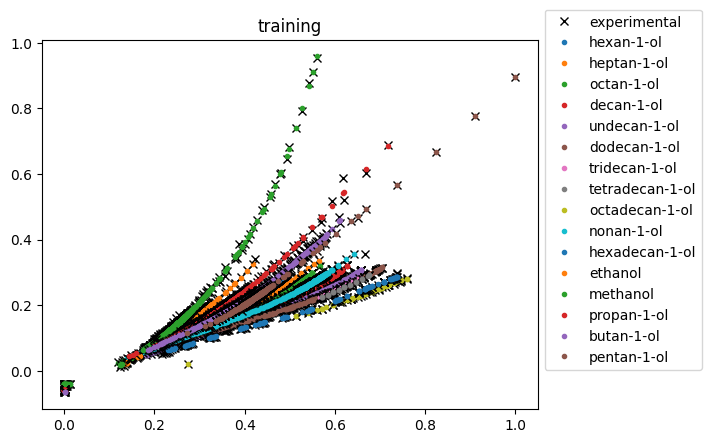

xxx torch.Size([350, 9])
xxx torch.Size([346, 9])
xxx torch.Size([487, 9])
xxx torch.Size([392, 9])
xxx torch.Size([239, 9])
xxx torch.Size([280, 9])
xxx torch.Size([13, 9])
xxx torch.Size([26, 9])
xxx torch.Size([42, 9])
xxx torch.Size([336, 9])
xxx torch.Size([90, 9])
xxx torch.Size([1151, 9])
xxx torch.Size([994, 9])
xxx torch.Size([1021, 9])
xxx torch.Size([1227, 9])
xxx torch.Size([508, 9])


/home/derwer/Desktop/PHD/deep_entropy_2/github/deep-entropy-scaling/deep_entropy_scaling/nn_training.py:566: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(resd_entropy, log_vis_star, deg)
/home/derwer/Desktop/PHD/deep_entropy_2/github/deep-entropy-scaling/deep_entropy_scaling/nn_training.py:566: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(resd_entropy, log_vis_star, deg)
/home/derwer/Desktop/PHD/deep_entropy_2/github/deep-entropy-scaling/deep_entropy_scaling/nn_training.py:566: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(resd_entropy, log_vis_star, deg)
/home/derwer/Desktop/PHD/deep_entropy_2/github/deep-entropy-scaling/deep_entropy_scaling/nn_training.py:566: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(resd_entropy, log_vis_star, deg)
/home/derwer/Desktop/PHD/deep_entropy_2/github/deep-entropy-scaling/deep_entropy_scaling/nn_training.py:566: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(res

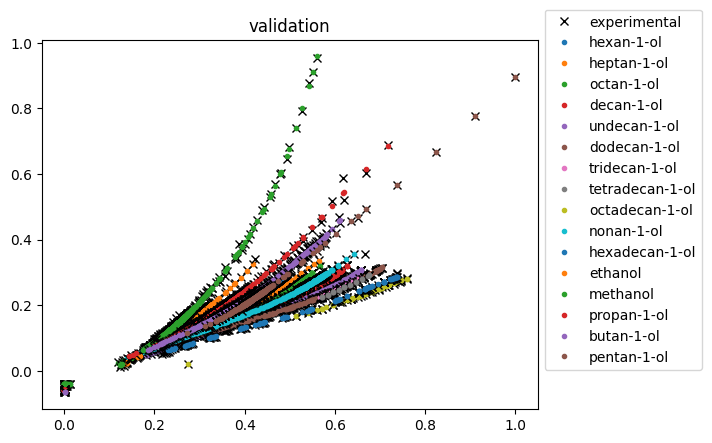

xxx torch.Size([350, 9])
xxx torch.Size([346, 9])
xxx torch.Size([487, 9])
xxx torch.Size([392, 9])
xxx torch.Size([239, 9])
xxx torch.Size([280, 9])
xxx torch.Size([13, 9])
xxx torch.Size([26, 9])
xxx torch.Size([42, 9])
xxx torch.Size([336, 9])
xxx torch.Size([90, 9])
xxx torch.Size([1151, 9])
xxx torch.Size([994, 9])
xxx torch.Size([1021, 9])
xxx torch.Size([1227, 9])
xxx torch.Size([508, 9])


/home/derwer/Desktop/PHD/deep_entropy_2/github/deep-entropy-scaling/deep_entropy_scaling/nn_training.py:566: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(resd_entropy, log_vis_star, deg)
/home/derwer/Desktop/PHD/deep_entropy_2/github/deep-entropy-scaling/deep_entropy_scaling/nn_training.py:566: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(resd_entropy, log_vis_star, deg)
/home/derwer/Desktop/PHD/deep_entropy_2/github/deep-entropy-scaling/deep_entropy_scaling/nn_training.py:566: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(resd_entropy, log_vis_star, deg)
/home/derwer/Desktop/PHD/deep_entropy_2/github/deep-entropy-scaling/deep_entropy_scaling/nn_training.py:566: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(resd_entropy, log_vis_star, deg)
/home/derwer/Desktop/PHD/deep_entropy_2/github/deep-entropy-scaling/deep_entropy_scaling/nn_training.py:566: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(res

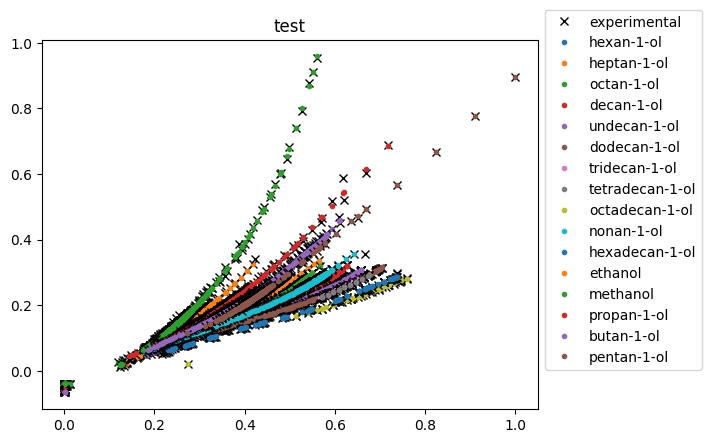

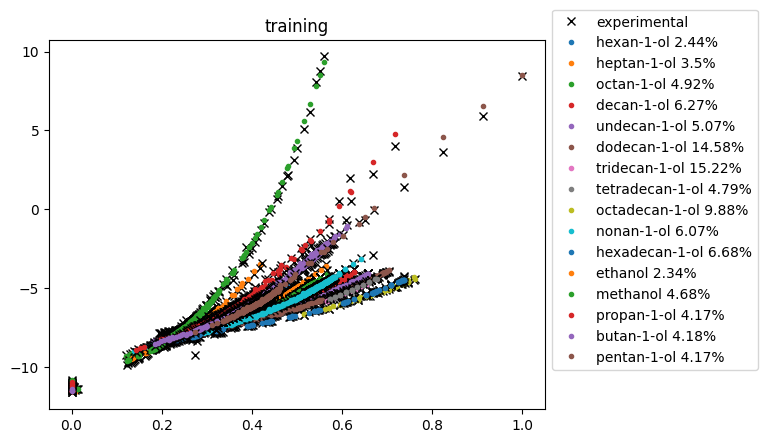

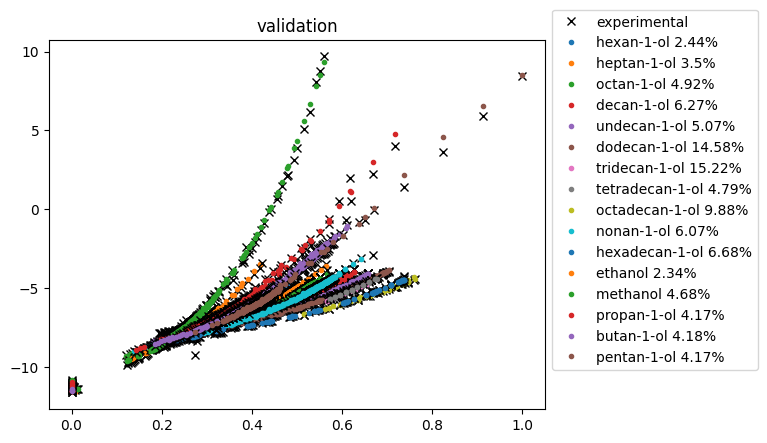

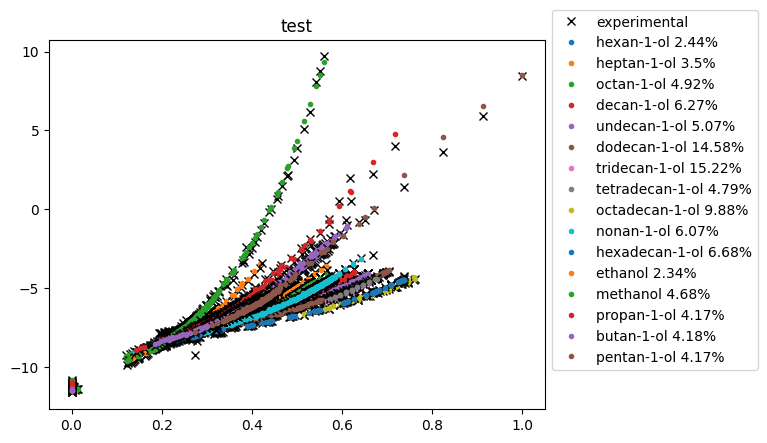

In [2]:
# config["data_csv_test"] = dpath + "vis_entropy_test_deduped.csv"
cname = os.path.join(best_result.checkpoint.to_directory(), "checkpoint.pt")
final_result = {**best_result.metrics, **best_result.config, **config,
                "checkpoint_path": cname,
                "n_entropy_features": best_result.config["n_features"]}
model, data_train = best_model(final_result, exp_error=True)


In [3]:
y_features = ["log_value"]

path = config["model_path"]

scalerX = minmax_from_json(path+'Xscaler.json')
scalerY = minmax_from_json(path+'Yscaler.json')    

data_train = dataset(config["data_csv_train"], y_features=y_features,
                             scalerX=scalerX, scalerY=scalerY, keepXY=True,keep_features=["iupac_name","family","canonical_smiles"])
data_val = dataset(config["data_csv_val"], y_features=y_features,
                           scalerX=scalerX, scalerY=scalerY, keepXY=True,keep_features=["iupac_name","family","canonical_smiles"])
data_test = dataset(config["data_csv_test"], y_features=y_features,
                            scalerX=scalerX, scalerY=scalerY, keepXY=True,keep_features=["iupac_name","family","canonical_smiles"])

KeyError: "['canonical_smiles'] not in index"

In [ ]:
exp_error = True


#a = ["training", "validation", "test"]
#b = [data_train, data_val, data_test]
a = ["training", ]
b = [data_train, ]
ps = []
ks = []
for dd, data in zip(a, b):

    X = data.X_scaled
    Y = data.Y_scaled
    
    y_pred = model(X)

    Y = scalerY.inverse_transform(Y.detach().numpy())
    y_pred = scalerY.inverse_transform(y_pred.detach().numpy())
    
    yy = np.squeeze(Y)
    y_pred = np.squeeze(y_pred)

    if exp_error:
        error = np.abs((np.exp(y_pred) - np.exp(yy)) / np.exp(yy))
    else:
        error = np.mean(np.abs((y_pred - yy) / yy))  

    xxx = X[:,1]#[ error >= error_max]
    yyy = Y[:,0]#[ error >= error_max]
    xerror = error#[ error >= error_max]      
    
    xx = X[:,1]#[ error < error_max]
    yy = y_pred#[ error < error_max]
    error = error#[ error < error_max]        
    mean_error = np.mean(error)*100
    median_error = np.median(error)*100        
    rmse_error = np.sqrt(np.mean(error**2))
   
    
    plt.plot( xxx, yyy, "kx", label="x"+dd )
    plt.plot( xx, yy, ".", label=dd, alpha=1 )
    #plt.plot( xx, error, ".", label=dd )
    #plt.plot( xxx, xerror, ".", label=dd )
    print(mean_error, median_error, rmse_error)
plt.legend()

In [ ]:
cname = os.path.join(config["model_path"], "checkpoint.pt")
final_result = {**config,
                "checkpoint_path": cname,
                "n_entropy_features": config["n_features"]}
model, data_train = best_model(final_result, exp_error=True)